In [6]:
!pip install tensorflow keras split-folders opencv-python

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import cv2
import os
import random
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models

In [3]:
input_folder = '/Users/e4ekhan/Hackathon/Pics'
output_folder = '/Users/e4ekhan/Hackathon/ImageRecognition'

split_ratio = (0.8, 0.1, 0.1)

splitfolders.ratio(
    input_folder,
    output = output_folder,
    seed = 500,
    ratio = split_ratio,
    group_prefix = None
)

Copying files: 7322 files [00:09, 758.85 files/s]


In [5]:
# Define the parameters
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [7]:
# Data augmentation for test data (only rescaling)
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
# Data augmentation for validation data (only rescaling)
valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [9]:
train_dir = os.path.join(output_folder, 'train')
val_dir = os.path.join(output_folder, 'val')
test_dir = os.path.join(output_folder, 'test')

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

valid_data = valid_datagen.flow_from_directory(
    val_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 5855 images belonging to 5 classes.
Found 736 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..100.061].


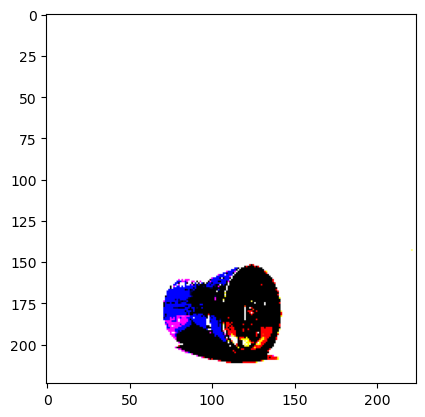

In [25]:
# Get a batch of images and labels
images, labels = next(valid_data)

# Select a random image from the batch
idx = random.randint(0, images.shape[0] - 1)

# Display the image
plt.imshow(images[idx])
plt.show()

In [27]:
from keras.applications.resnet import ResNet50
base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (img_size[0], img_size[1], 3))

# Freeze the convolutional base
base_model.trainable = False

In [29]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation = 'softmax')
])

In [31]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [33]:
model.fit(train_data, epochs = 10, validation_data = valid_data)

C:\Users\e4ekhan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.8157 - loss: 0.5760 - val_accuracy: 0.9425 - val_loss: 0.1597
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.9238 - loss: 0.2198 - val_accuracy: 0.9549 - val_loss: 0.1314
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.9382 - loss: 0.1834 - val_accuracy: 0.9631 - val_loss: 0.1167
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.9510 - loss: 0.1470 - val_accuracy: 0.9631 - val_loss: 0.1137
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.9553 - loss: 0.1224 - val_accuracy: 0.9699 - val_loss: 0.0976
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.9619 - loss: 0.1116 - val_accuracy: 0.9685 - val_loss: 0.1006
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.9656 - loss: 0.1025 - val_accuracy: 0.9603 - val_loss: 0.1144
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.9623 - loss: 0.1013 - val_accu

In [35]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9613 - loss: 0.1734
Test Accuracy: 97.15%


In [37]:
class_names = {0: 'Compostable', 1: 'Ewaste', 2: 'Hazardous', 3: 'Recyclables', 4: 'Textile'}

In [39]:
def predict_img(image, model):
    test_img = cv2.imread(image)
    test_img = cv2.resize(test_img,(224,224))
    test_img = np.expand_dims(test_img, axis = 0)
    result = model.predict(test_img)
    r = np.argmax(result)
    print(class_names[r])

In [49]:
predict_img('/Users/e4ekhan/Downloads/208206.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Hazardous


In [51]:
predict_img('/Users/e4ekhan/Downloads/$_57.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Hazardous


In [45]:
predict_img('/Users/e4ekhan/Downloads/Bottles.png', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Compostable


In [47]:
predict_img('/Users/e4ekhan/Downloads/paper.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Hazardous


In [53]:
model.save('NewModel.keras')